<a href="https://colab.research.google.com/github/ShengpeiWang/Reimplement_simple_NN/blob/master/Reimplement_simple_NN_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reimplementing a simple neural network is a good to way to learn DL
- In my other project applying BERT model to text classification, I struggled with modifying other people's PyTorch code to my purpose. Although I understood generally what the different components did, my struggle impelled me to gain a deeper understanding of PyTorch. And there’s no better way to do that than reimplementing some of PyTorch’s basic functionalities from the ground up. This is also giving me a deeper understanding of deep learning fundamentals.    
- This is part of my notes from the fast.ai course (part 2), where I reimplemented some of PyTorch’s functionalities in their barest forms. I often learn by looking at other people’s code, and hopefully this can help other DL beginners to start playing with their models.

In [1]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


In [2]:
# functions to check that out code work here
def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

## Get the MNIST data
Which data doesn't really matter for my purpose here. The MNIST is a simple problem to start with.

In [3]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [4]:
x_train,y_train,x_valid,y_valid = get_data()
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()
# Look at the shapes of the data, making sure they are sensible

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

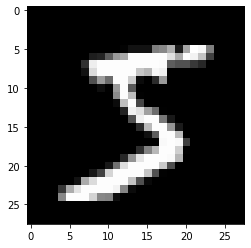

In [5]:
# look at the first image:
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
plt.imshow(img.view((28,28)));

In [6]:
train_mean,train_std = x_train.mean(),x_train.std()
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

## Pythonic implementation of matrix multiplication
Matrix multiplication is fundamental to neural networks, it's worth knowing a little how to implement it in code.

In [7]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  assert ac == br
  c = torch.zeros(ar, bc)
  for i in range(ar):
    c[i,:] =  (a[i][:,None] * b).sum(dim = 0)
  return c

In [8]:
a = tensor([10,20,30,40,50,60]).view(2,3)
b = tensor([1,2,3,4,5,6]).view(3,2)
b

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [9]:
matmul(a,b)

tensor([[220., 280.],
        [490., 640.]])

In [10]:
# compare with pytorch's operation
a.matmul(b)

tensor([[220, 280],
        [490, 640]])

## Initialize a simple model with a single hidden layer

In [11]:
n,m = x_train.shape # input shape
c = y_train.max()+1 # output shape
nh = 50 # num hidden cells
n,m,c

(50000, 784, tensor(10))

In [12]:
# initialize the weights and biases
# simplified kaiming init / he init
w1 = torch.randn(m,nh)*math.sqrt(2/(1+m)) # note that I added a 1 to m (originally math.sqrt(2/(m))) to better replicate the ResNet paper's implementation 
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh) # this is different than w1 because there is not a relu layer after like the first layer
b2 = torch.zeros(1)

In [13]:
# here is how to do the initializing using pytorch:
from torch.nn import init
w1 = torch.zeros(m,nh)
init.kaiming_normal_(w1, mode='fan_out') # use the pytorch version of the kaiming init

tensor([[ 0.0091, -0.0519, -0.0576,  ...,  0.1136,  0.0081, -0.0036],
        [ 0.1169,  0.0147,  0.0049,  ..., -0.0246,  0.0364,  0.0220],
        [-0.0542,  0.0476, -0.0105,  ...,  0.0496,  0.0189, -0.0666],
        ...,
        [ 0.0815, -0.0367,  0.0296,  ...,  0.0790, -0.0221, -0.0071],
        [ 0.0100,  0.0424, -0.0246,  ..., -0.1029, -0.0214,  0.0361],
        [ 0.0840, -0.0197, -0.0790,  ...,  0.0654, -0.0302,  0.0347]])

# Implement forward and backward passes of a linear layer, Rely, and MSE
For each component, the forward pass is calculated when the class is called, and the backward pass is calculated when the backward function is called.

In [14]:
class Relu():
  def __call__(self, inp):
    self.inp = inp
    self.out = self.inp.clamp_min(0.) - 0.5 # the -0.5 is to facilitate training by making the outputs with mean close to zero and standard deviation close to 1
    return self.out
  
  def backward(self):
    self.inp.g = (self.inp > 0).float() * self.out.g

In [15]:
class Lin():
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def __call__(self, inp):
    self.inp = inp
    self.out = self.inp @ self.w + self.b
    return self.out

  def backward(self):
    self.inp.g = self.out.g @ self.w.t()
    self.w.g = self.inp.t() @ self.out.g
    self.b.g = self.out.g.sum(0)

In [16]:
class Mse():
  def __call__(self, inp, targ):
    self.inp = inp
    self.targ = targ
    self.out = (self.inp.squeeze(1) - self.targ).pow(2).mean()
    return self.out

  def backward(self):
    self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.inp.shape[0]

In [17]:
class Model():
  def __init__(self, w1, b1, w2, b2):
    self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
    self.loss = Mse()
  
  def __call__(self, x, targ):
    for l in self.layers: x = l(x)
    return self.loss(x, targ)

  def backward(self):
    self.loss.backward()
    for l in reversed(self.layers): l.backward()


In [18]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [19]:
%time loss = model(x_train, y_train)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 145 ms


In [20]:
loss

tensor(33.6131)

In [21]:
%time model.backward()

CPU times: user 225 ms, sys: 1.88 ms, total: 227 ms
Wall time: 228 ms


## Refactor the repetetive code using the Module class
- The module class handles assigning arguments, and calling the forward and backward passes. 
- This makes the code both faster and easier to read (when things get more complicated).

In [22]:
class Module():
  def __call__(self, *args):
    self.args = args
    self.out = self.forward(*args)
    return self.out
  
  def forward(self): raise Exception('not implemented')
  def backward(self): self.bwd(self.out, *self.args)

In [23]:
# Example class to test how the Module class work
# I was rather cofused about how the Module class works, so I wrote this to help me dissect all the name spaces
class print_args(Module):
  def __init__(self, a, b):
    self.a = a
    self.b = b
  
  def forward(self, inp1, inp2):
    return [self.a, self.b, self.b, inp1, inp2]
  
  def bwd(self, out, inp1, inp2): 
  # note that 'out' has to be the first argument after self, because how bwd is called in the module class
  # also note that all of the arguments given to the forward method need to be listed here, otherwise a TypeError is raised 
    print("backward", out, inp1, inp2, self.a, self.b)

In [24]:
a = print_args("first", "second")

In [25]:
a("input1", "input2") 

['first', 'second', 'second', 'input1', 'input2']

In [26]:
a.backward()

backward ['first', 'second', 'second', 'input1', 'input2'] input1 input2 first second


In [27]:
class Relu(Module):
  def forward(self, inp):   return inp.clamp_min(0.) - 0.5
  def bwd(self, out, inp):  inp.g = (inp > 0).float() * out.g

In [28]:
class Lin(Module):
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def forward(self, inp): return inp @ self.w + self.b
  
  def bwd(self, out, inp):
    inp.g = out.g @ self.w.t()
    self.w.g = inp.t() @ out.g
    self.b.g = out.g.sum(0)

In [29]:
class Mse(Module):
  def forward(self, inp, targ):
    return (inp.squeeze(1) - targ).pow(2).mean()

  def bwd(self, out, inp, targ):
    inp.g = 2. * (inp.squeeze() -  targ).unsqueeze(-1) / inp.shape[0]

In [30]:
class Model():
  def __init__(self):
    self.layer = [Lin(w1,b1), Relu(), Lin(w2,b2)]
    self.loss = Mse()

  def __call__(self, x, targ):
    for l in self.layer: x = l(x)
    return self.loss(x, targ)

  def backward(self):
    self.loss.backward()
    for l in reversed(self.layer): l.backward()

In [31]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [32]:
%time loss = model(x_train, y_train)

CPU times: user 134 ms, sys: 1.56 ms, total: 135 ms
Wall time: 140 ms


In [33]:
loss

tensor(33.6131)

In [34]:
%time model.backward()

CPU times: user 221 ms, sys: 82.2 ms, total: 303 ms
Wall time: 305 ms


### compare our code with pytorch's implementations: nn.Module and nn.*Linear*

In [35]:
from torch import nn

def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [36]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)

In [37]:
model = Model(m, nh, 1)

In [38]:
%time loss = model(x_train, y_train)

CPU times: user 111 ms, sys: 946 µs, total: 112 ms
Wall time: 114 ms


In [39]:
loss
# Note that because the relu is implemented differently in our code than Pytorch's, the loss is different here

tensor(26.4548, grad_fn=<MeanBackward0>)

In [40]:
%time loss.backward()
# PyTorch's implementation of backward is twice as fast

CPU times: user 88.1 ms, sys: 3.65 ms, total: 91.7 ms
Wall time: 97.3 ms
